# Problem definition: Classification of Amyloid PET images into healthy and AD.


In this jupyter notebook, you will learn to classify Amyloid PET images into healthy/congitively normal (CN) and Alzheimer's disease (AD) by using transfer learning using a pre-trained network.


You will learn 2 ways of customizing a pre-trained network:
1. Feature extraction: Use the representations learnt by the pre-trained model to extract features from the new images. You just add a classifer layer which will be trained from scratch on top of the pretrained model. You do not need to retrain the entire model.
2. Fine-tuning: Unfreeze few top layers of the frozen model and jointly train with the newly added classifier layer and the last layers of the base model.This allows us to "fine-tune" the higher order representations in the base model to make it more suitable for the task in hand. .  


**Objectivies (What will we learn here?)**

1. Setting up the env
2. Create training, validation and test ids
3. Image pre-processing
4. Image augmentation
5. Building the classification model
6. Feature extraction
7. Looking at learning curves
8. Fine-tuning
9. Looking at the learning curves
10. Predicting using the build model
11. What next? It is time to play!

## Step 1: Set up the env

In [1]:
# Importing necessary libraries for building and training neural networks
import os
import numpy as np  # For numerical operations with arrays
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
from pathlib import Path  # For managing file paths
import torch  # Core PyTorch library for building neural networks
import torch.nn as nn  # Provides modules and classes for neural network layers
import torch.optim as optim  # Contains optimization algorithms like SGD and Adam
from torch.utils.data import DataLoader, Dataset  # Data loading utilities
from torchvision import models, transforms  # Pre-trained models and image transformations
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.utils import shuffle  # For shuffling the data
from skimage.color import gray2rgb
from PIL import Image

Let's install pydicom which is the library we will use for reading dicom images

In [2]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 75.9 MB/s eta 0:00:00


In [3]:
import pydicom

Because we are working on data stored in Google Cloud Storage bucket, the following steps will need to be taken:

Install gcsfuse it is a package used to mount the cloud bucket on to your local environment.

1. Authenticate your google account

2. Create a new directory to mount the storage bucket

3. Use gcsfuse to mount the storage bucket

4. You can browse throught the storage bucket here

In [4]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v1.4.0/gcsfuse_1.4.0_amd64.deb; \
    dpkg --install gcsfuse_1.4.0_amd64.deb; \
    apt-get update; \
    apt-get clean;

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,317 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,610 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu ja

Now call google authentication with the following code block and allow access in the pop-up window

In [5]:
from google.colab import auth
auth.authenticate_user()

Let's set the project id and storage bucket id

In [6]:
project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Updated property [core/project].


You can list using gsutil to see if we have the correct storage

In [7]:
!gsutil ls

gs://csc-509-image-files/


Let's make a new directory called images to mount our bucket

In [8]:
!mkdir images

Call gcsfuse to mount the bucket

In [9]:
!gcsfuse --implicit-dirs csc-509-image-files images

{"time":"20/02/2025 11:54:18.914078","severity":"INFO","msg":"Start gcsfuse/1.4.0 (Go version go1.21.5) for app \"\" using mount point: /content/images\n"}


In [10]:
!ls images/

Archive				Module0_UPENNGBM  Module1_BraTS.tar.bz2  Module2_ADNI_New
Module0_DataCuration		Module1_ADNI	  Module1_PET
Module0_MRI_PET_Classification	Module1_BraTS	  Module2_ADNI


In [11]:
!pwd

/content


## Step 2: Now let's create the training, validation and test ids.

In [12]:
# Define where the image data is located
DATA_PATH = Path('/content/images/Module1_PET/PET/')
csv_file = '/content/images/Module1_PET/adni_pet_metadata_file.csv'


In [13]:
# Load metadata about the images into a DataFrame
data_df = pd.read_csv(csv_file)

In [14]:
!ls /content/images/Module1_PET/PET/AD_CN_baseline_Uniform_Resolution/AD/ | wc -l


141


In [15]:
!ls /content/images/Module1_PET/PET/AD_CN_baseline_Uniform_Resolution/CN/ | wc -l


181


In [16]:
data_df.subject_id.nunique()

330

In [17]:

def check_middle_slice_exists(data_df):
    file_exists_list = []
    for index, row in data_df.iterrows():
        if index % 10 == 0:
            print(index)
        path = os.path.join(DATA_PATH, row["middle_slice"])
        if os.path.exists(path):
            file_exists_list.append(1)
        else:
            print(f"Middle slice not found for: {row['middle_slice']}")
            file_exists_list.append(0)
    data_df['file_exists'] = file_exists_list
    return data_df


In [18]:
data_df = check_middle_slice_exists(data_df)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
Middle slice not found for: AD_CN_baseline_Uniform_Resolution/AD/073_S_5016_I365866/PET_Slice_048.dcm
240
250
260
270
Middle slice not found for: AD_CN_baseline_Uniform_Resolution/AD/024_S_4280_I265274/PET_Slice_048.dcm
280
290
300
Middle slice not found for: AD_CN_baseline_Uniform_Resolution/AD/009_S_5224_I386055/PET_Slice_048.dcm
310
Middle slice not found for: AD_CN_baseline_Uniform_Resolution/AD/006_S_4546_I300104/PET_Slice_048.dcm
Middle slice not found for: AD_CN_baseline_Uniform_Resolution/AD/006_S_4192_I268115/PET_Slice_048.dcm
320
Middle slice not found for: AD_CN_baseline_Uniform_Resolution/AD/005_S_4910_I342830/PET_Slice_048.dcm
Middle slice not found for: AD_CN_baseline_Uniform_Resolution/AD/003_S_4373_I282305/PET_Slice_048.dcm
Middle slice not found for: AD_CN_baseline_Uniform_Resolution/AD/002_S_5018_I347760/PET_Slice_048.dcm


In [19]:
data_df = data_df.drop(data_df[data_df['file_exists'] == 0].index)

In [20]:
data_df = data_df.reset_index(drop =True)

From the data wrangling and preprocessing exercise we have already created a csv with middle slices of the Amyloid PET images. Let's read that csv file.

In [21]:
data_df.head(n=2)

,group,folder,n_images,middle_slice_index,subject_id,image_id,middle_slice,copied_from,copied_from1,copied_from2,copied_from3,copied_from4,copied_from5,copied_from6,file_exists
0,CN,AD_CN_baseline_Uniform_Resolution/CN/941_S_437...,96,48,941_S_4376,I283676,AD_CN_baseline_Uniform_Resolution/CN/941_S_437...,ADNI2_baseline_AV45_PET/941_S_4376/AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2012-02-03_15_17_12.0/I283...,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20120209140414341_48_S1...,1
1,CN,AD_CN_baseline_Uniform_Resolution/CN/941_S_436...,96,48,941_S_4365,I276956,AD_CN_baseline_Uniform_Resolution/CN/941_S_436...,ADNI2_baseline_AV45_PET/941_S_4365/AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2012-01-06_15_23_36.0/I276...,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20120110093755859_48_S1...,1


In [22]:
data_df.group.value_counts()

,count
group,
CN,181
AD,141


In [23]:
# Split the list of unique image IDs into train, validation, and test sets
ids = data_df['subject_id'].unique()  # Unique identifiers for images
ids[0]

'941_S_4376'

In [24]:
train_ids, test_ids = train_test_split(ids, test_size=0.20, random_state=0)  # 20% for testing
train_ids, val_ids = train_test_split(train_ids, test_size=0.20, random_state=0)  # 20% of remaining for validation

In [25]:
print(len(train_ids), len(val_ids), len(test_ids))

205 52 65


## We already understand what each of these groups mean:

- CN : Cognitively normal
- MCI : Mild cognitive impairment
- EMCI : Early mild cognitive impairment
- LMCI: Late mild cognitive impairment
- AD : Alzheimer's disease
- SMC : Significant memory concerns

Spatial pattern of amyloid deposition in AD: https://onlinelibrary.wiley.com/doi/10.1002/hbm.23018

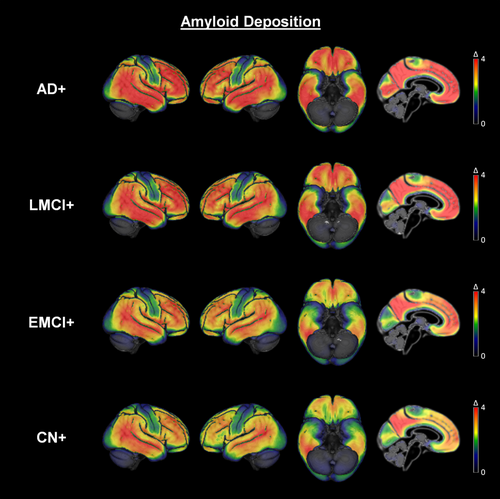



In [26]:
data_df.subject_id.nunique()

322

In [27]:
data_df.shape

(322, 15)

What are types of classification in deep learning: https://machinelearningmastery.com/types-of-classification-in-machine-learning/

About train, validation and test sets: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

Scikit-learn train, validation and test splits: https://stackabuse.com/scikit-learns-traintestsplit-training-testing-and-validation-sets/

In [28]:
# Let's check the number of patients ids in train, validation and test set
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 205 patient ids in training set
There are 52 patient ids in validation set
There are 65 patient ids in test set


In [29]:
# Let's check the number of CN and AD patients in the splits. We want our splits to be balanced.
data_df['Split'] = np.where(data_df['subject_id'].isin(train_ids), 'Train', '')
data_df['Split'] = np.where(data_df['subject_id'].isin(val_ids), 'Validation', data_df['Split'])
data_df['Split'] = np.where(data_df['subject_id'].isin(test_ids), 'Test', data_df['Split'])

data_df.groupby(by = ['Split','group'])['subject_id'].agg('nunique').reset_index()

,Split,group,subject_id
0,Test,AD,22
1,Test,CN,43
2,Train,AD,105
3,Train,CN,100
4,Validation,AD,14
5,Validation,CN,38


What to do when your train and test data comes from different distributions: https://www.freecodecamp.org/news/what-to-do-when-your-training-and-testing-data-come-from-different-distributions-d89674c6ecd8/

## Step 3: Let's instantiate the pytorch custom imaging dataset and wrap the processing steps within it.

Why do we normalize images for deep learning: https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d

How do you know you have enough training data or sample size: https://towardsdatascience.com/how-do-you-know-you-have-enough-training-data-ad9b1fd679ee

Normally, we wrap the loading, normalization, and processing inside the dataset - however, we want you to learn to do these steps manually so we're asking that you instead look at each of the functions separately.

In [30]:
class PETDataset(Dataset):
    """Custom dataset for loading and preprocessing PET images and labels."""
    def __init__(self, dataframe, data_path, transform=None):
        self.dataframe = dataframe
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def dicom_to_pil(self, dicom_path):
        """Converts a DICOM file to a PIL Image.

        Args:
            dicom_path: Path to the DICOM file.

        Returns:
            A PIL Image object, or None if an error occurs.
        """
        try:
            dicom = pydicom.dcmread(dicom_path)
            image = dicom.pixel_array.astype(np.int16)  # Ensure int16

            # Normalize the image to 0-255 range for PIL
            min_val = np.min(image)
            max_val = np.max(image)
            normalized_image = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)

            # Convert grayscale to RGB if needed
            if len(normalized_image.shape) == 2:  # Check if grayscale
                pil_image = Image.fromarray(normalized_image, mode='L').convert("RGB")
            else:
              pil_image = Image.fromarray(normalized_image)

            return pil_image
        except Exception as e:
            print(f"Error converting DICOM to PIL: {e}")
            return None

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]


        # Convert label to binary
        label = 0 if row['group'] == 'CN' else 1

        img_path = os.path.join(self.data_path, row['middle_slice'])
        img_pil = self.dicom_to_pil(img_path)

        if self.transform:
            img_pil = self.transform(img_pil)

        return img_pil, label

In [31]:
# Define transformations to apply to images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Resize((224, 224)),  # Resize image
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize image with mean and std
])



In [32]:
train_df = data_df.loc[data_df['Split'] == 'Train']
val_df = data_df.loc[data_df['Split'] == 'Validation']
test_df = data_df.loc[data_df['Split'] == 'Test']

In [33]:
train_dataset = PETDataset(train_df, DATA_PATH, transform=transform)
val_dataset = PETDataset(val_df, DATA_PATH, transform=transform)
test_dataset = PETDataset(test_df, DATA_PATH, transform=transform)

In [34]:
vars(train_dataset).keys() ## Looks at the dataset object and allows you to take a closer look/debug

dict_keys(['dataframe', 'data_path', 'transform'])

In [35]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [36]:
x, y = next(iter(train_loader))

<ipython-input-30-cc998530ced4>:27: RuntimeWarning: overflow encountered in scalar subtract
  normalized_image = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)


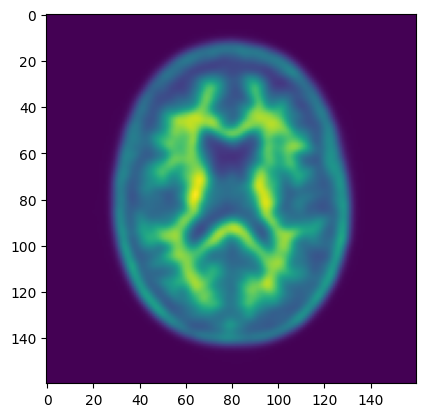

In [37]:
plt.imshow(x[0,0])

It takes a long time to create the numpy arrays. We just want to execute this step once and save the numpy arrays as .npy files so that we can reuse the files for out hyper-parameter tuning.

**Please change the location of the files to your own location. Else you will overwrite the previously created files in the shared folder.**


Now we will read the .npy files and start our model training!We have a numpy arrays already created and saved in the shared folder.

**Please save a copy of the files to your own location and read files from that location.**

In [38]:
# # Let's load the train, validation and test arrays
# X_train = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_train_images.npy', allow_pickle=True)
# X_val = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_val_images.npy', allow_pickle=True)
# X_test = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_test_images.npy', allow_pickle=True)
# Y_train = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_train_label.npy', allow_pickle=True)
# Y_val = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_val_label.npy', allow_pickle=True)
# Y_test = np.load('/content/images/Module2_ADNI/Numpy_files/AmyPET_test_label.npy', allow_pickle=True)

The images are not 3 channel. Inorder to use Imagenet weights, we will need 3 channel images. The next step converts the images to 3 channel.

What are grayscale abd RGB images: https://www.analyticsvidhya.com/blog/2021/03/grayscale-and-rgb-format-for-storing-images/

In [39]:
# # Converting grayscale images to RGB
# X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
# X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
# X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

Because we have mulitple images from same patient, we need to shuffle the training set. We will also shuffle the validation and test sets.

Wht shuffling is recommended in deep learning: https://www.deepwizai.com/simply-deep/why-random-shuffling-improves-generalizability-of-neural-nets

Colormaps in matplotlib: https://www.analyticsvidhya.com/blog/2020/09/colormaps-matplotlib/

2 articles on effect of batch size on training:
1. https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/#:~:text=Batch%20size%20controls%20the%20accuracy,stability%20of%20the%20learning%20process.

2. https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

Optimizing performance with AUTOTUNE: https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4

## Step 4: Let's look at image augmentation now.

Augmentation is a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation. This helps expose the model to different aspects of the training data and reduce overfitting.

Note: Augmentation should be applied only on the training set.

How is augmentation helpful in deep learning: https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/

Data augmentation using tensorflow: https://www.tensorflow.org/tutorials/images/data_augmentation

In [40]:
transform_augmented = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15, expand=False, center=None),
            transforms.RandomAffine(15, translate = (.05, 0.05)),
            transforms.ColorJitter(brightness = 0.05, contrast = 0.05, saturation = 0.05, hue = 0.05),
            transforms.ToTensor(),
            ])

In [41]:
train_dataset_augmented = PETDataset(train_df, data_path = DATA_PATH, transform = transform_augmented)

In [42]:
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size = 1)

In [43]:
X_aug, y_aug = next(iter(train_loader_augmented))

In [44]:
X_aug.shape

torch.Size([1, 3, 160, 160])

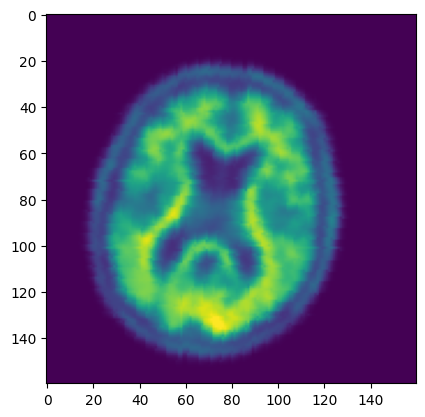

In [45]:
plt.imshow(X_aug[0,0])

# Step 5: Building the Model with ResNet18 in PyTorch
## Understanding Pre-trained Models and Feature Extraction
In this step, we will use the ResNet18 pre-trained network to extract features from our PET images. This approach leverages the powerful and informative features learned from the ImageNet dataset, which contains 1.4 million images across 1000 different classes. By using a pre-trained model, we can take advantage of this prior knowledge to classify images as Cognitively Normal (CN) or Alzheimer's Disease (AD).

Pre-trained Networks: These are models that have already been trained on large datasets like ImageNet, which consist of a wide variety of categories. Using pre-trained models helps in learning new tasks faster and more accurately because they start with already learned features.

ResNet18: This is one of the many models pre-trained on ImageNet. It is known for its simplicity and effectiveness in extracting features through its residual learning framework. We will use the layer before the final fully connected layer for feature extraction.

Steps to Use ResNet18 in PyTorch
Load Pre-trained ResNet18: We will use PyTorch's torchvision.models to load the ResNet18 model with pre-trained ImageNet weights.
Modify the Model: Remove the top classification layer to use the model for feature extraction.
Normalize Input Data: Ensure input images are normalized to match the expected input format of ResNet18, which is [0, 1].

In [46]:
# Step 1: Load the pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Step 2: Modify the model for feature extraction
# We don't need the final classification layer, so we'll replace it
# Get the number of input features for the final layer
num_features = resnet18.fc.in_features
# Replace the final fully connected layer with an identity layer for feature extraction
resnet18.fc = nn.Identity()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.4MB/s]


In [47]:
# Move the model to the appropriate device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# Step 3: Define transformations for input normalization
# ResNet18 expects input images that are normalized to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # ResNet18 expects 224x224 input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for ResNet
])


This feature extractor converts each 3x160x160 image into a 3x3x2048 block of features. Let's see what it does to an example batch of images.

In [49]:
# Example: Using the model to extract features from an input batch
def extract_features(loader, model, device):
    model.eval()  # Set the model to evaluation mode
    features = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, _ in loader:
            inputs = inputs.to(device)
            # Forward pass through the model to extract features
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())

    # Concatenate all features into a single array
    return np.concatenate(features, axis=0)

In [50]:
# Now you can use the transform to preprocess your data and the function to extract features
train_loader = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

# Extract features
train_features = extract_features(train_loader, resnet18, device)


<ipython-input-30-cc998530ced4>:27: RuntimeWarning: overflow encountered in scalar subtract
  normalized_image = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)


In [58]:
train_features.shape

(205, 512)

## Step 6: Feature extraction


In this step, we will freeze the convolutional base created from the previous step and use as a feature extractor. Additionally, we will add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.




In [ ]:
# InceptionV3 has many layers, so setting the entire model's trainable flag to False will freeze all of them.
base_model.trainable = False

Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this notebook.

When we set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When we unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, we should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

What is batch normalization: https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338

What is global average pooling:https://www.machinecurve.com/index.php/2020/01/30/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling/

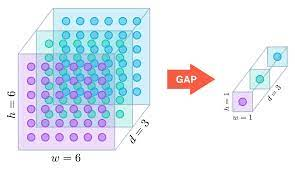

In [ ]:
# Add a classification head.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

We will now apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.
We don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

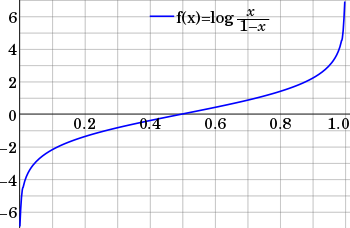

Classification problem in deep learning: https://medium.com/deep-learning-with-keras/how-to-solve-classification-problems-in-deep-learning-with-tensorflow-keras-6e39c5b09501

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Now let's build a model by using everything we have learnt so far -  the data augmentation, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Let's compile the model before training it. Since there are two classes, we will use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output. We will start with a very small learning rate.

What do you mean by model compilation: https://techvidvan.com/tutorials/keras-model-compilation-evaluation-prediction/

We use a fixed learning rate here, is there a way to have anadjustable learning rate: https://neptune.ai/blog/how-to-choose-a-learning-rate-scheduler

Learning rate scheduler in tensorflow: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

In [ ]:
# Compile the model

base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

What are the different optimizers in tensorflow: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [ ]:
# Let's look at the model summary
model.summary()

The 21M parameters in InceptionV3 are frozen, but there are 2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

Let's do the model training now! We will train for 5 epochs.

In [ ]:
# Train the model

initial_epochs =5

loss0, accuracy0 = model.evaluate(val_dataset)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

## Step 7: Now let's take a look at the learning curve.

Learning curves are a widely used diagnostic tool in machine learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves.

Why is learning curve important: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

In [ ]:
# Learning curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Step 8: Fine-tuning

In the feature extraction experiment, were were only training a few layers on top of an InceptionV3 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, it's good to note that we should try to fine-tune a small number of top layers rather than the whole InceptionV3 model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [ ]:
# Un-freeze the top layers of the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Now let's compile the model. As we are training a much larger model and want to readapt the pre-trained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/5),
              metrics=['accuracy'])

In [ ]:
# Let's take a look at the model summary
model.summary()

In [ ]:
# Let's look at the number of trainable variables now.
len(model.trainable_variables)

Let's continue to train the model. If we were able to train the model to convergence earlier, this step will further improve the accuracy.

Here we have selected a fixed number of epochs.

Is there a way you can stop the model from training when it starts overfitting: https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/

Early stopping in tensorflow: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

## Step 9: Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the InceptionV3 base model and training the classifier on top of it.


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Step 10: Evaluate the model.

We can now verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

## Step 11: What next? Time to play!
As a home-work or self learning task, you can try a variety of experiments to understand how the model performance is affected.

You can also do some of this as your term project.

Try to think about what could improve the model performance?

1. Will changing the size of training set help? We are just 10 slices per volume, will using more or less slices change anything?
2. Will more data augmentation help improve the performance?
3. Will changing the hyper-parameters like optimizer, learning rate, loss function, epochs, batch size improve the model performance? For ex. What will happen if you change the optimizer to SGD?
4. Will changing the model achitecture help? Check tf.keras.applications for different model architectures like - VGG16, VGG19, ResNet50, etc.
5. How is the learning curve for this trained model? Is it underfitting or overfitting? Does it need more training? How much training is enough and when should I stop?
6. How about using FDG PET instead of Amyloid PET? Will that give a better result?
7. How about using a differnt performance metrics?

And there is so much more! This is just a starting point. Model training and hyper-parameter tuning is the fun part of any deep learning project.

Next what? In this example we learnt a binary or 2 class classification problem. It can be extended to a multi-class problem.

Another fun task to do would be to try a multi-class classification where you can try and predict the different groups like CN, AD, LMCI, etc. What will you need to modify in the current code to change it to a multi-class problem ? (Hint: Loss function, prediction layer)

Multi-lable classification in tensorflow: https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72

How to do hyper-parameter tuning: https://towardsdatascience.com/the-art-of-hyperparameter-tuning-in-deep-neural-nets-by-example-685cb5429a38



In [ ]:
# Some functions to help with model training

# Function to create numpy array for using just 1 slice per volume
def create_numpy_array(df):
    X = []
    Y = []


    for i in range(len(df)):

        ds = pydicom.dcmread(df['FILEPATH_MIDDLE_SLICES'][i])
        image = gray2rgb(ds.pixel_array)
        label = df['Group'][i]
        new_image, new_label = normalize(image, label)
        X.append(new_image)
        Y.append(new_label)

    return np.asarray(X), np.asarray(Y)

In [ ]:
# For using FDG PET

# Let's create a function to normalize the image between -1 and 1 and change label to 0 and 1
def normalize(image, label, percentile = 0.001,
              eps = 0.0000001):


    img_array = np.ndarray.flatten(image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    input_image = tf.cast(img_normalized, tf.float32)/255

    input_label = 0 if label == 'CN' else 1


    return input_image, input_label

# Write a function to sort by SliceLocation and select the middle slice from each dicom folder

def select_middle_slice(foldername):

    dicom_files = glob.glob(foldername + "/*.dcm")
    slices = [pydicom.read_file(s) for s in dicom_files]
    slices.sort(key = lambda x: int(x.SliceLocation))
    image = slices[int(len(slices)/2)].pixel_array
    print(np.max(image))


    return gray2rgb(image)

# Let's create numpy arrays of training, validation and test images.

# For the sake of simplicity, we will use only the middle slice of each volume for this experiment.
def create_numpy_array(df):
    X = []
    Y = []

    for i in range(len(df)):
        print(i)
        folder = df['FILEPATH_FDGPET_DICOM_FOLDER'][i]
        print(folder)
        try:
          image = select_middle_slice(folder)
          label = df['Group'][i]
          new_image, new_label = normalize(image, label)
          X.append(new_image)
          Y.append(new_label)
        except IndexError:
          print("IndexError")
        except AttributeError:
          print("AttributeError")
        except:
          print("InvalidDicomError")



    return np.asarray(X), np.asarray(Y)